In [1]:
import numpy 
import math

class SpreadOption():
    def __init__(self, expiry):
        self.expiry = expiry
    def payoff(self, S1, S2):
        return max(S1-S2, 0)
    def valueAtNode(self, t, S1, S2, continuation):
        return continuation

def calib2D(r, q1, q2, vol1, vol2, rho, t):
    sqrtt = math.sqrt(t)
    v1 = r - q1 - vol1 * vol1 / 2
    v2 = r - q2 - vol2 * vol2 / 2
    x1 = vol1 * sqrtt
    x2 = vol2 * sqrtt
    a = x1 * x2
    b = x2 * v1 * t
    c = x1 * v2 * t
    d = rho * vol1 * vol2 * t
    puu = (a + b + c + d)/4/a
    pud = (a + b - c - d)/4/a
    pdu = (a - b + c - d)/4/a
    pdd = (a - b - c + d)/4/a
    return (x1, x2, puu, pud, pdu, pdd)

def binomialPricer2D(S1, S2, r, q1, q2, vol1, vol2, rho, trade, n):
    t = trade.expiry / n
    (x1, x2, puu, pud, pdu, pdd) = calib2D(r, q1, q2, vol1, vol2, rho, t)
    vs = numpy.zeros(shape=(n+1, n+1))
    for i in range(n+1):
        s1i = S1 * math.exp(x1 * (n - 2 * i))
        for j in range(n+1):
            s2j = S2 * math.exp(x2 * (n - 2*j))
            vs[i, j] = trade.payoff(s1i, s2j)
    # iterate backward
    for k in range(n - 1, -1, -1):
        # calculate the value of each node at time slide k, there are (k+1) x (k+1) nodes
        for i in range(k + 1):
            s1i = S1 * math.exp(x1 * (k - 2*i))
            for j in range(k + 1):
                s2j = S2 * math.exp(x2 * (k - 2*j))
                continuation = math.exp(-r * t) * (vs[i, j] * puu + vs[i, j+1] * pud + vs[i+1, j] * pdu + vs[i+1, j+1] * pdd)
                vs[i, j] = trade.valueAtNode(t * k, s1i, s2j, continuation)
    return vs[0, 0]


In [2]:
def cnorm(x):
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

# analytic solution for spread option
def margrabe(S1, S2, q1, q2, vol1, vol2, rho, T):
    sigma = math.sqrt(vol1*vol1 + vol2*vol2 - 2*rho*vol1*vol2)
    stdev = sigma * math.sqrt(T)
    d1 = (math.log(S1 / S2) + (q2 - q1) * T) / stdev + stdev / 2
    d2 = d1 - stdev
    return math.exp(-q1*T) * S1 * cnorm(d1) - math.exp(-q2*T) * S2 * cnorm(d2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


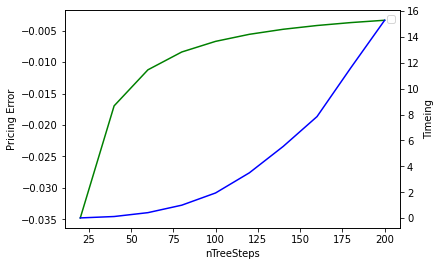

In [3]:
import time
import matplotlib.pyplot as plt
def testSpreadOption():
    S1, S2, r, q1, q2, vol1, vol2, rho = 100, 100, 0.05, 0.02, 0.03, 0.15, 0.2, 0.6
    spreadOption = SpreadOption(expiry = 1)
    refPrice = margrabe(S1, S2, q1, q2, vol1, vol2, rho, T = 1.0)

    n = 10
    prc = [None] * n
    timing = [None] * n
    nSteps = [None] * n
    for i in range(1, n+1):
        nSteps[i - 1] = 20 * i
        start = time.time()
        prc[i-1] = binomialPricer2D(S1, S2, r, q1, q2, vol1, vol2, rho, spreadOption, nSteps[i-1]) - refPrice
        timing[i-1] = time.time() - start

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(nSteps, prc, 'g')
    ax2.plot(nSteps, timing, 'b')

    ax1.set_xlabel('nTreeSteps')
    ax1.set_ylabel('Pricing Error')
    ax2.set_ylabel('Timeing')
    plt.legend()
    plt.show()

# this test takes a while to run
testSpreadOption()

Compare the timing with 1D binomial tree, 1D is much faster when nSteps grows

In [20]:
from enum import Enum
class PayoffType(Enum):
    Call = 0
    Put = 1
    
class EuropeanOption():
    def __init__(self, expiry, strike, payoffType):
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        else:
            raise Exception("payoffType not supported: ", self.payoffType)
    def valueAtNode(self, t, S, continuation):
        if continuation == None:
            return self.payoff(S)
        else:
            return continuation


def bsPrice(S, r, vol, T, strike, payoffType):
    fwd = S * math.exp(r * T)
    stdev = vol * math.sqrt(T)
    d1 = math.log(fwd / strike) / stdev + stdev / 2
    d2 = d1 - stdev
    if payoffType == PayoffType.Call:
        return math.exp(-r * T) * (fwd * cnorm(d1) - cnorm(d2) * strike)
    elif payoffType == PayoffType.Put:
        return math.exp(-r * T) * (strike * cnorm(-d2) - cnorm(-d1) * fwd)
    else:
        raise Exception("not supported payoff type", payoffType)

def tianCalib(r, vol, t):
    v = math.exp(vol * vol * t)
    u = 0.5 * math.exp(r * t) * v * (v + 1 + math.sqrt(v*v + 2*v - 3))
    d = 0.5 * math.exp(r * t) * v * (v + 1 - math.sqrt(v*v + 2*v - 3))
    p = (math.exp(r * t) - d) / (u - d)
    return (u, d, p)

def binomialPricer(S, r, vol, trade, n, calib):
    t = trade.expiry / n
    (u, d, p) = calib(r, vol, t)
    # set up the last time slice, there are n+1 nodes at the last time slice
    vs = [trade.payoff(S * u ** (n - i) * d ** i) for i in range(n + 1)]
    # iterate backward
    for i in range(n - 1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(i + 1):
            nodeS = S * u ** (i - j) * d ** j
            continuation = math.exp(-r * t) * (vs[j] * p + vs[j + 1] * (1 - p))
            vs[j] = trade.valueAtNode(t * i, nodeS, continuation)
    return vs[0]

bsPrice = 	  6.297254539086019


No handles with labels found to put in legend.


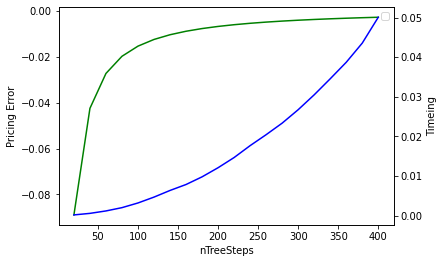

In [16]:
def test1DTiming():
    opt = EuropeanOption(1, 105, PayoffType.Call)
    S, r, vol = 100, 0.01, 0.2

    bsprc = bsPrice(S, r, vol, opt.expiry, opt.strike, opt.payoffType)
    print("bsPrice = \t ", bsprc)
    n = 20
    prc = [None] * n
    timing = [None] * n
    nSteps = [None] * n
    for i in range(1, n + 1):
        nSteps[i - 1] = 20 * i
        start = time.time()
        prc[i - 1] = binomialPricer(S, r, vol, opt, nSteps[i - 1], tianCalib) - bsprc
        timing[i - 1] = time.time() - start

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(nSteps, prc, 'g')
    ax2.plot(nSteps, timing, 'b')

    ax1.set_xlabel('nTreeSteps')
    ax1.set_ylabel('Pricing Error')
    ax2.set_ylabel('Timeing')
    plt.legend()
    plt.show()
    
test1DTiming()
